<a href="https://colab.research.google.com/github/mthsansu/MLNLP/blob/main/Code/Houri_Sansu_SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center><strong><font color="chillipepper">Parlementarian Sentiment Analysis</font></strong></center></h1>
<h5><center><font color="green">Machine learning for Natural Language Processing <h3><center>


<center>
Yasmine Houri, Mathis Sansu  


Lab supervisor: Roman Castagne  

ENSAE 2022
</center>

## Packages

In [ ]:
!pip install datasets
!pip install transformers
!pip install sentencepiece
!pip install keras
!pip install tensorflow
!pip3 install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
# Import packages used in the descriptive analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import re
import datetime as dt
import nltk
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.util import ngrams
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from collections import Counter
import seaborn as sns
import string

# Import packages for the baseline model
import torch
import datasets
from datasets import load_dataset
from tqdm import tqdm
import torchtext
from termcolor import colored
import torch
import torch.nn as nn
import torch.nn.functional as F

# Import packages for the task-specific model
import os
import time
import datetime
import random
# from tqdm.auto import tqdm
from scipy.special import softmax
from nltk.tokenize import sent_tokenize
from sklearn.metrics import classification_report,precision_recall_fscore_support, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from transformers import CamembertTokenizer, CamembertConfig,\
                         AdamW, get_linear_schedule_with_warmup,\
                         WEIGHTS_NAME, CONFIG_NAME
from transformers import CamembertForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
import matplotlib.pyplot as plt
import seaborn as sn

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Data

In [ ]:
# List of the datasets on which we will apply the operationns
list_data = ['Tweets_sample_confinement.csv', 'Tweets_sample_benalla.csv', 'Tweets_sample_CDM.csv']

In [ ]:
# Import data
git_url = "https://raw.githubusercontent.com/mthsansu/MLNLP/main/Data/"
df = pd.read_csv(git_url + 'Tweets_sample_confinement.csv', index_col=0, engine='python')
# df = pd.read_csv(git_url + 'Tweets_sample_CDM.csv', index_col=0, engine='python')
# df = pd.read_csv(git_url + 'Tweets_sample_benalla.csv', index_col=0, engine='python')

In [ ]:
# Create a date variable
df['date'] = df['created_at'].str[:10]
df['date'] = pd.to_datetime(df['date'])

In [ ]:
# # Restreindre pour CDM
# mask = (df['date'] >= '2018-07-10') & (df['date'] <= '2018-07-20')
# df = df.loc[mask]
# df["date"].describe()

In [ ]:
# # Restreindre pour Benalla
# mask = (df['date'] >= '2018-05-01') & (df['date'] <= '2018-05-15')
# df = df.loc[mask]
# df["date"].describe()

# <h1><center><strong><font color="chillipepper">Descriptive statistics</font></strong></center></h1>

## Word-level preprocessing

In [ ]:
# List of words with separator = " "
list_words = df.text.apply(lambda x: x.split(' ')).array
# Flattening to a single list
list_words = [x for X in list_words for x in X]
# Render the number of distinct words in the dataset
print('%s "words" in total for this dataset' % (len(set(list_words))))

147234 "words" in total for this dataset


In [ ]:
# Usage of Phrases and Phraser from gensim
import nltk
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def clean(text): # Parameter will be a text, here a tweet
    text = re.sub("@","", text) # Removing the "@" from mention
    text = re.sub(r'http\S+', '', text) # Removing url links
    text = text.replace('\n',' ') # Removing new line
    text = text.replace('\r',' ') # Removing new line
    text = re.sub('#', '', text) # Removing hash
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) # remove emoji
    a = re.compile('<U(.*?)>') # other missing emoji_pattern
    text = a.sub(r'', text) # remove these remaining emoji
    text = re.sub(' +', ' ', text) # Remove additional spaces
    return text # The output is the cleaned text

In [ ]:
# List of cleaned words
list_words_2 = df.text_clean.apply(lambda x: x.split(' ')).array
list_words_2 = [x for X in list_words_2 for x in X]
print('%s cleaned "words" in total for this dataset' % (len(set(list_words_2))))

81039 cleaned "words" in total for this dataset


In [ ]:
# List of tokens
list_tokens_1 = df.text.apply(lambda x: TweetTokenizer().tokenize(x)).array
list_tokens_1 = [x for X in list_tokens_1 for x in X]
print('%s tokens in total for this dataset' % (len(set(list_tokens_1))))

92561 tokens in total for this dataset


In [ ]:
# List of tokens
list_tokens_2 = df.text_clean.apply(lambda x: TweetTokenizer().tokenize(x)).array
list_tokens_2 = [x for X in list_tokens_2 for x in X]
print('%s "cleaned" tokens in total for this dataset' % (len(set(list_tokens_2))))

45314 "cleaned" tokens in total for this dataset


## First statistics on the complete set of data

In [ ]:
# Number of different tweets in the database
print(len(df.id.unique()),"tweets in total")

32767 tweets in total


In [ ]:
# Number of different MPs in the database
print(len(df.author_id.unique()),"distinct authors")

487 distinct authors


In [ ]:
# Distribution of tweets considered as possibly sensitive
print("Distribution of tweets considered as possibly sensitive \n", df.possibly_sensitive.value_counts())

Distribution of tweets considered as possibly sensitive 
 False    32552
True       215
Name: possibly_sensitive, dtype: int64


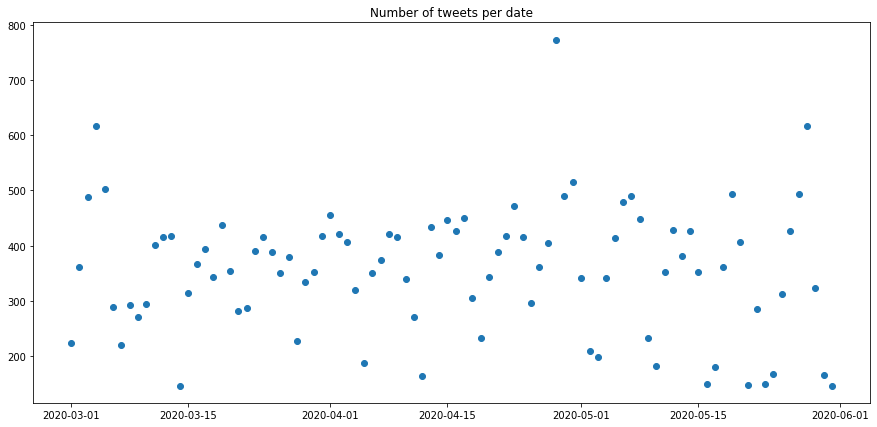

In [ ]:
# Plot the number of tweets per date
x = df.date.value_counts().index # Get the date as x-axis
y = df.date.value_counts() # Get the number of tweets per date as y-axis
figure(figsize=(15, 7))
plt.title('Number of tweets per date')
plt.plot_date(x, y, xdate=True)
plt.show() # Plot the graph

Number of tweets done by MPs age:


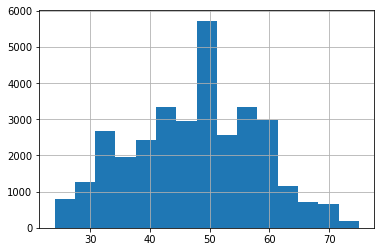

In [ ]:
print("Number of tweets done by MPs age:")
df.age.hist(bins=15)

Number of tweets done by political group:


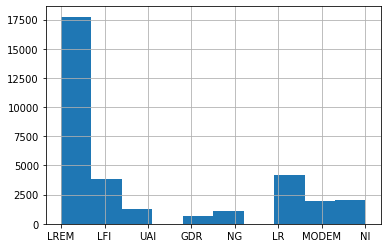

In [ ]:
print("Number of tweets done by political group:")
df.groupe_sigle.hist()

In [ ]:
print("Distribution of tweets by gender \n", df.sexe.value_counts())

Distribution of tweets by gender 
 M    19966
F    12801
Name: sexe, dtype: int64


In [ ]:
print("Distribution of tweets by number of mandates \n", df.nb_mandats.value_counts())

Distribution of tweets by number of mandates 
 1    24594
2     7576
3      597
Name: nb_mandats, dtype: int64


In [ ]:
print("Distribution of tweets according to majority belonging \n", df.majo.value_counts())

Distribution of tweets according to majority belonging 
 True     21179
False    11588
Name: majo, dtype: int64


## Some statistics on tweets themselves

In [ ]:
# Mean length of tweets in characters
print("Mean length of tweets in characters:",df.text.apply(len).mean())

Mean length of tweets in characters: 255.04104739524522


In [ ]:
# Number of "words": we split by a space(naive approach)
df['words_len'] = df.text_clean.apply(lambda x: len(x.split(' ')) )

In [ ]:
# Mean length of tweets in characters
print("Mean length of tweets in characters:",df.words_len.mean())

Mean length of tweets in characters: 32.64015625476852


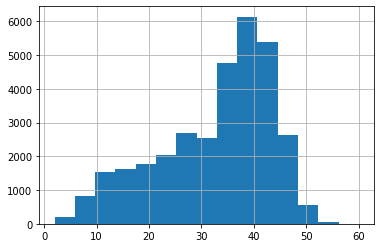

In [ ]:
# Distribution of tweets according to length in words
df.words_len.hist(bins=15)

In [ ]:
# Storing the average word length for each tweet
df["chr_len_words"] = df['text_clean'].str.split(' |-').\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x))

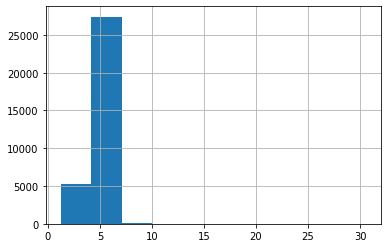

In [ ]:
# Distribution of tweets according to average words length in number of characters
df.chr_len_words.hist()

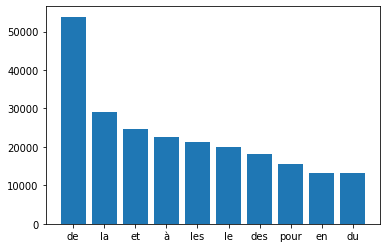

In [ ]:
# Analysis of stopwords
# Code taken from: https://app.neptune.ai/neptune-ai/eda-nlp-tools/n/1-3-top-stopwords-barchart-b953763c-3fea-4331-bff0-429411793e5f/5c0fca05-ba07-4564-a02e-c44b08bfb8cb

stop=set(stopwords.words('french'))

def plot_top_stopwords_barchart(text):
    
  new= df.text_clean.str.split()
  new=new.values.tolist()
  corpus=[word for i in new for word in i]
  from collections import defaultdict
  dic=defaultdict(int)
  for word in corpus:
      if word in stop:
          dic[word]+=1
          
  top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
  x,y=zip(*top)
  plt.bar(x,y)

plot_top_stopwords_barchart(df["text_clean"])

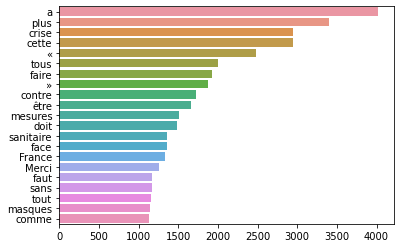

In [ ]:
# Most frequent words

corpus=[]
new= df.text_clean.str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:80]:
    if (word.lower() not in stop):
      if (word.lower() not in list(string.punctuation)):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

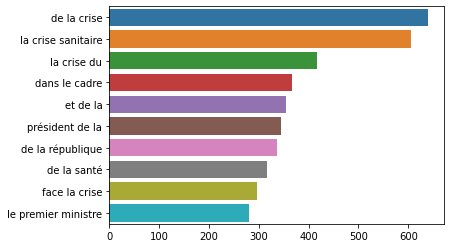

In [ ]:
# Tri-gram exploration
# Code taken from: https://app.neptune.ai/neptune-ai/eda-nlp-tools/n/2-0-top-ngrams-barchart-671a187d-c3b4-475a-bc9e-8aa6c937923b/c427446f-7b0e-4621-b791-47b0fd31a39e

def plot_top_ngrams_barchart(text, n=2):

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)


plot_top_ngrams_barchart(df['text_clean'],3)

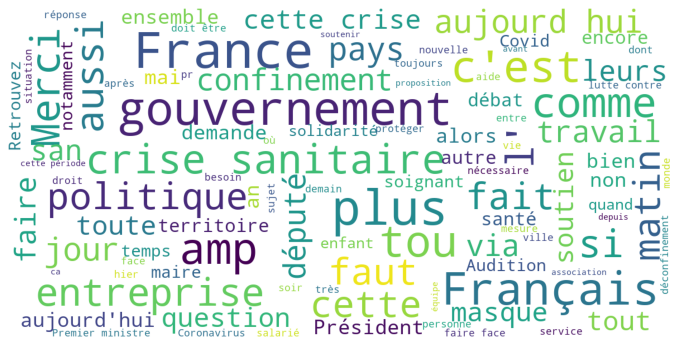

In [ ]:
from wordcloud import WordCloud, STOPWORDS
stopwords = stop

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    text = ' '.join(data)
    wordcloud=wordcloud.generate(text)

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)

# <h1><center><strong><font color="chillipepper">Sequence Classification</font></strong></center></h1>
<h3><center><font color="green"><strong>Baseline Model</strong></font></center></h3>

## <font color="chillipepper">Data</font>

**Import the annotated data**

In [ ]:
# Import data
git_url = "https://raw.githubusercontent.com/mthsansu/MLNLP/main/Data/"
df = pd.read_csv(git_url + 'df_baseline.csv', index_col =0)

In [ ]:
df["text"] = df["text"].apply(lambda x: clean(x))

In [ ]:
df = df.rename(columns={'Label': 'label'})

**Prepare the data for machine learning tasks**

In [ ]:
# Randomly split the data into train, test and validation sets using numpy
train, validate, test = \
              np.split(df.sample(frac=1, random_state=42), 
                       [int(.6*len(df)), int(.8*len(df))])

In [ ]:
import pyarrow as pa
import pyarrow.dataset as ds
from datasets import Dataset

### convert to Huggingface dataset
train_dataset = Dataset(pa.Table.from_pandas(train))
test_dataset = Dataset(pa.Table.from_pandas(test))
val_dataset = Dataset(pa.Table.from_pandas(validate))

## <font color="chillipepper">Pre-trained Embeddings</font>

**First NLP tasks**

In [ ]:
# Run only once: several min long
# Import fasttext vectors through torch text (it will download it only once)
from torchtext.vocab import vocab, FastText

pretrained_vectors = FastText(language='fr')

.vector_cache/wiki.fr.vec: 3.03GB [01:30, 33.4MB/s]                            
100%|██████████| 1152449/1152449 [02:40<00:00, 7170.70it/s]


In [ ]:
pretrained_vocab = vocab(pretrained_vectors.stoi)
unk_token = "<unk>"
unk_index = 0
pad_token = '<pad>'
pad_index = 1
pretrained_vocab.insert_token("<unk>",unk_index)
pretrained_vocab.insert_token("<pad>", pad_index)
#this is necessary otherwise it will throw runtime error if OOV token is queried 
pretrained_vocab.set_default_index(unk_index)
pretrained_embeddings = pretrained_vectors.vectors
pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),pretrained_embeddings))
pretrained_embeddings.size()

torch.Size([1152450, 300])

## <font color="chillipepper">Tokenization</font>

In [ ]:
# Import nltk's TweetTokenizer to use it in the definition of our own tokenizer functions
from nltk.tokenize import TweetTokenizer
from tqdm.notebook import tqdm

tok = TweetTokenizer()

In [ ]:
# This function will tokenize each tweet, standardize the string sizes using zero-padding, and numericalize each token to an index
def tokenize_pad_numericalize(entry, vocab_stoi, max_length=20):
  text = [ vocab_stoi[token] if token in vocab_stoi else vocab_stoi['<unk>'] for token in tok.tokenize(entry.lower())]
  padded_text = None
  if len(text) < max_length:   padded_text = text + [ vocab_stoi['<pad>'] for i in range(len(text), max_length) ] 
  elif len(text) > max_length: padded_text = text[:max_length]
  else:                        padded_text = text
  return padded_text

# This function is a generalization of the function above, now applicable to multiple tweets at a time
def tokenize_all(entries, vocab_stoi):
  res = {}
  res['text'] = [tokenize_pad_numericalize(entry, vocab_stoi, max_length=200) for entry in entries['text']]
  return res

In [ ]:
# Tokenize our three data subsets
train_dataset = train_dataset.map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)
test_dataset = test_dataset.map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)
val_dataset = val_dataset.map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

## <font color="chillipepper">Building of the model</font>

In [ ]:
# Create the Dataset class

from torch.utils.data import Dataset

class TweetDataset(Dataset):
    def __init__(self, data, args):
      # args is a dict, a nice way to share the global arguments (even accross multiple files)
      self.args = args
      self.data = data

    def __len__(self):
      return len(self.data)
    
    def __getitem__(self, idx):
      item = {
          "text": np.array(self.data[idx]['text']),
          "label": np.array(self.data[idx]['label'])
      }
      return item

In [ ]:
# Create DataLoader
from torch.utils.data import DataLoader
args = {'bsize': 64}
train_loader = DataLoader(TweetDataset(train_dataset, args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
test_loader  = DataLoader(TweetDataset(test_dataset, args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
val_loader  = DataLoader(TweetDataset(val_dataset, args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)

In [ ]:
# Define the model to classify tweets

class TweetModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, pretrained_vectors=None):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TweetModel, self).__init__()
        # apply the pretrained embeddings to transform our token indices, into vectors
        self.ebd = torch.nn.Embedding.from_pretrained(pretrained_vectors, freeze=True)
        self.hidden_linear_layer = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.classification_layer = torch.nn.Linear(hidden_dim, output_dim, bias=True)
        # softmax layer to compute class probabilities
        # https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html?highlight=softmax#torch.nn.Softmax
        self.softmax = nn.Softmax(dim=1)

        # define the dropout strategy (here, 20% (0.2) of the vector is ignored to prevent overfitting)
        # we don't use it here but it's a good thing to keep in mind
        # self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        # apply the pretrained embeddings
        x  = self.ebd(x)
        x  = x.mean(1)
        h  = torch.relu(self.hidden_linear_layer( x ))
        # h  = self.dropout(h)
        h  = self.classification_layer(h)
        logits = self.softmax(h)
        return logits

In [ ]:
sizes = next(iter(train_loader))['text'].size()
batchsize = sizes[0] # We have chosen a batchsize equal to 64
inputdim  = sizes[1] # The input layer of our NN has 200 elements because when we padded the data, we set max_length=200
print(batchsize, inputdim)

64 200


In [ ]:
hiddendim = 300 # dimension of the pretrained vector
outputdim = 3 # because there is 3 classes, i.e. 3 labels
# we instanciate the model
tweet_model = TweetModel(inputdim, hiddendim, outputdim, pretrained_vectors=pretrained_vectors.vectors)

In [ ]:
# we can look at the model 
tweet_model

TweetModel(
  (ebd): Embedding(1152449, 300)
  (hidden_linear_layer): Linear(in_features=300, out_features=300, bias=True)
  (classification_layer): Linear(in_features=300, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

**We'll need a GPU**

In [ ]:
if torch.cuda.is_available():
  device = 'cuda'
  print('DEVICE = ', colored(torch.cuda.get_device_name(0), "green" ) )
else:
  device = 'cpu'
  print('DEVICE = ', colored('CPU', "blue"))
tweet_model.to(device)

DEVICE =  Tesla K80


TweetModel(
  (ebd): Embedding(1152449, 300)
  (hidden_linear_layer): Linear(in_features=300, out_features=300, bias=True)
  (classification_layer): Linear(in_features=300, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

**Train the model**

In [ ]:
# Training loop

def train(model, optimizer, ep, args):
  # set the model into a training mode : the model's weights and parameters WILL BE updated!
  model.train()
  # initialize empty lists for losses and accuracies
  loss_it, acc_it = list(), list()

  # start the loop over all the training batches. This means one full epoch.
  for it, batch in tqdm(enumerate(train_loader), desc="Epoch %s:" % (ep), total=train_loader.__len__()):
    
    batch = {'text': batch['text'].to(device), 'label': batch['label'].to(device)}

    # put parameters of the model and the optimizer to zero before doing another iteration. this prevents the gradient accumulation through batches
    optimizer.zero_grad()

    # apply the model on the batch
    logits = model(batch['text'])

    # # # to deal with unbalanced data in the batch, we calculate the weights according to their inverse frequency
    b_counter = Counter(batch['label'].detach().cpu().tolist())
    b_weights = torch.tensor( [ sum(batch['label'].detach().cpu().tolist()) / b_counter[label] if b_counter[label] > 0 else 0 for label in list(range(args['num_class'])) ] )
    b_weights = b_weights.to(device)

    # we choose the CrossEntropyLoss, suitable for multiclass classification
    # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
    loss_function = nn.CrossEntropyLoss(weight=b_weights)
    # loss_function = nn.CrossEntropyLoss()
    loss = loss_function(logits, batch['label'])

    # compute backpropagation
    loss.backward()

    # indicate to the optimizer we've done a step
    optimizer.step()

    # append the value of the loss for the current iteration (it). .item() retrieve the nuclear value as a int/long
    loss_it.append(loss.item())

    # get the predicted tags using the maximum probability from the softmax
    _, tag_seq  = torch.max(logits, 1)
    
    # Those 3 lines compute the accuracy and then append it the same way as the loss above
    correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
    acc = correct / batch['label'].flatten().size(0)
    acc_it.append(acc.item())

  # simple averages of losses and accuracies for this epoch
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information about the training progress and scores on this training set's full pass (i.e. 1 epoch)
  print("Epoch %s/%s : %s : (%s %s) (%s %s)" % (colored(str(ep), 'blue'),args['max_eps'] , colored('Training', 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))


In [ ]:
def inference(target, loader, model):
  """
    Args:
      target (str): modify the display, usually either 'validation' or 'test'
  """

  # set the model into a evaluation mode : the model's weights and parameters will NOT be updated!
  model.eval()

  # intialize empty list to populate later on
  loss_it, acc_it, f1_it = list(), list(), list()
  # preds = predicted values ; trues = true values .... obviously~
  preds, trues = list(), list()

  # loop over the loader batches
  for it, batch in tqdm(enumerate(loader), desc="%s:" % (target), total=loader.__len__()):
    # set an environnement without any gradient. So the tensor gradients are not considered 
    # (saves a lot of computation and memory, this is one of the many things that makes predicting far less costly than training)
    with torch.no_grad():

      # put the batch to the correct device
      batch = {'text': batch['text'].to(device), 'label': batch['label'].to(device)}

      # apply the model
      logits = model(batch['text'])

      # # to deal with unbalanced data in the batch, we calculate the weights according to their inverse frequency
      # b_counter = Counter(batch['label'].detach().cpu().tolist())
      # b_weights = torch.tensor( [ sum(batch['label'].detach().cpu().tolist()) / b_counter[label] if b_counter[label] > 0 else 0 for label in list(range(20)) ] )
      # b_weights = b_weights.to(device)

      # loss_function = nn.CrossEntropyLoss(weight=b_weights)
      loss_function = nn.CrossEntropyLoss()
      loss = loss_function(logits, batch['label'])

      # no need to backward() and other training stuff. Directly store the loss in the list
      loss_it.append(loss.item())

      # get the predicted tags using the maximum probability from the softmax
      _, tag_seq  = torch.max(logits, 1)
      
      # compute the accuracy and store it
      correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
      acc = correct / batch['label'].flatten().size(0)
      acc_it.append(acc.item())
      
      # extend the predictions and true labels lists so we can compare them later on
      # note how we first ensure the tensor are on cpu (.cpu()), then we detach() the gradient from the tensor, before transforming it to a simple python list (.tolist())
      preds.extend(tag_seq.cpu().detach().tolist())
      trues.extend(batch['label'].cpu().detach().tolist())

  # compute the average loss and accuracy accross the iterations (batches)
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information. Important during training as we want to know the performance over the validation set after each epoch
  print("%s : (%s %s) (%s %s)" % ( colored(target, 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))

  # return the true and predicted values with the losses and accuracies
  return trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it

In [ ]:
# Start training

import torch.optim as optim

def run_epochs(model, args):

  # args['device'] =device
  if args['cuda'] != -1:
      model.cuda(args['cuda'])
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      args['device'] = device
      print("device set to %s" % (device) )

  # we set the optimizer as Adam with the learning rate (lr) set in the arguments
  # you can look at the different optimizer available here: https://pytorch.org/docs/stable/optim.html
  optimizer = optim.Adam(model.parameters(), lr = args['lr'])

  # define an empty list to store validation losses for each epoch
  val_ep_losses = list()
  # iterate over the number of max epochs set in the arguments
  for ep in range(args['max_eps']):
    # train the model using our defined function
    train(model, optimizer, ep, args)
    # apply the model for inference using our defined function
    trues, preds, val_loss_it_avg, val_acc_it_avg, val_loss_it, val_acc_it = inference("validation", val_loader, model)
    # append the validation losses (good losses should normally go down)
    val_ep_losses.append(val_loss_it_avg)

  # return the list of epoch validation losses in order to use it later to create a plot
  return val_ep_losses
    

In [ ]:
def predict(target, loader, model):
  """
    Args:
      target (str): modify the display, usually either 'validation' or 'test'
  """

  # set the model into a evaluation mode : the model's weights and parameters will NOT be updated!
  model.eval()

  # intialize empty list to populate later on
  #loss_it, acc_it, f1_it = list(), list(), list()
  # preds = predicted values ; trues = true values .... obviously~
  #preds, trues = list(), list()
  ids, preds = list(), list()

  # loop over the loader batches
  for it, batch in tqdm(enumerate(loader), desc="%s:" % (target), total=loader.__len__()):
    # set an environnement without any gradient. So the tensor gradients are not considered 
    # (saves a lot of computation and memory, this is one of the many things that makes predicting far less costly than training)
    with torch.no_grad():

      # put the batch to the correct device
      batch = {'text': batch['text'].to(device), 'id': batch['id'].to(device)}
      #batch = {'text': batch['text'].to(device)}

      # apply the model
      logits = model(batch['text'])

      # # to deal with unbalanced data in the batch, we calculate the weights according to their inverse frequency
      # b_counter = Counter(batch['label'].detach().cpu().tolist())
      # b_weights = torch.tensor( [ sum(batch['label'].detach().cpu().tolist()) / b_counter[label] if b_counter[label] > 0 else 0 for label in list(range(20)) ] )
      # b_weights = b_weights.to(device)

      # loss_function = nn.CrossEntropyLoss(weight=b_weights)
      #loss_function = nn.CrossEntropyLoss()
      #loss = loss_function(logits, batch['label'])

      # no need to backward() and other training stuff. Directly store the loss in the list
      #loss_it.append(loss.item())

      # get the predicted tags using the maximum probability from the softmax
      _, tag_seq  = torch.max(logits, 1)
      
      # compute the accuracy and store it
      #correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
      #acc = correct / batch['label'].flatten().size(0)
      #acc_it.append(acc.item())
      
      # extend the predictions and true labels lists so we can compare them later on
      # note how we first ensure the tensor are on cpu (.cpu()), then we detach() the gradient from the tensor, before transforming it to a simple python list (.tolist())
      preds.extend(tag_seq.cpu().detach().tolist())
      ids.extend(batch['id'].cpu().detach().tolist())

  # compute the average loss and accuracy accross the iterations (batches)
  #loss_it_avg = sum(loss_it)/len(loss_it)
  #acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information. Important during training as we want to know the performance over the validation set after each epoch
  #print("%s : (%s %s) (%s %s)" % ( colored(target, 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))

  # return the true and predicted values with the losses and accuracies
  #return trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it
  return ids, preds

In [ ]:
# here you can specify if you want a GPU or a CPU by setting the cuda argument as -1 for CPU and another index for GPU. If you only have one GPU, put 0.
args.update({'max_eps': 80, 'lr': 0.001, 'device': 'gpu', 'cuda': 0, 'num_class': 3})
# 1e-05
print('device', device)
# Instantiate model with pre-trained glove vectors
# model = TweetModel(pretrained_embeddings, args['num_class'], args, dimension=50, freeze_embeddings = True )
tweet_model = TweetModel(inputdim, hiddendim, outputdim, pretrained_vectors=pretrained_vectors.vectors)
loss_list_val = run_epochs(tweet_model, args)

device cuda
device set to cuda


Epoch 0::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 0/80 : Training : (loss 1.0979168944888644) (acc 0.3854166666666667)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0957567691802979) (acc 0.421875)


Epoch 1::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/80 : Training : (loss 1.0960181686613295) (acc 0.390625)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0922046105066936) (acc 0.4375)


Epoch 2::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/80 : Training : (loss 1.0929845306608412) (acc 0.3975694444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0904771486918132) (acc 0.4166666666666667)


Epoch 3::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/80 : Training : (loss 1.0888407760196261) (acc 0.4045138888888889)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0869308312733967) (acc 0.421875)


Epoch 4::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/80 : Training : (loss 1.0823607312308416) (acc 0.4114583333333333)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0843136310577393) (acc 0.4114583333333333)


Epoch 5::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/80 : Training : (loss 1.076923131942749) (acc 0.4027777777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0749457677205403) (acc 0.40625)


Epoch 6::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/80 : Training : (loss 1.0696701208750408) (acc 0.4079861111111111)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.065824826558431) (acc 0.4166666666666667)


Epoch 7::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/80 : Training : (loss 1.0670951737297907) (acc 0.4097222222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0670652786890666) (acc 0.40625)


Epoch 8::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/80 : Training : (loss 1.0613257884979248) (acc 0.4184027777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0768529971440632) (acc 0.3958333333333333)


Epoch 9::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/80 : Training : (loss 1.057872348361545) (acc 0.4253472222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0918893019358318) (acc 0.3802083333333333)


Epoch 10::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/80 : Training : (loss 1.0602349307801988) (acc 0.4253472222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0775280396143596) (acc 0.4166666666666667)


Epoch 11::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11/80 : Training : (loss 1.053727560573154) (acc 0.4704861111111111)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0586922566095989) (acc 0.421875)


Epoch 12::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12/80 : Training : (loss 1.0536217557059393) (acc 0.40625)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.079542835553487) (acc 0.3958333333333333)


Epoch 13::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13/80 : Training : (loss 1.051512532764011) (acc 0.4600694444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0668702125549316) (acc 0.421875)


Epoch 14::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14/80 : Training : (loss 1.047242244084676) (acc 0.4375)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0718786716461182) (acc 0.4166666666666667)


Epoch 15::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15/80 : Training : (loss 1.0437043640348647) (acc 0.46875)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0748890240987141) (acc 0.4010416666666667)


Epoch 16::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 16/80 : Training : (loss 1.0449058082368639) (acc 0.4409722222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.069352626800537) (acc 0.4375)


Epoch 17::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 17/80 : Training : (loss 1.0407075617048476) (acc 0.4913194444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0624615748723347) (acc 0.4270833333333333)


Epoch 18::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 18/80 : Training : (loss 1.0382998916837904) (acc 0.484375)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.068608323733012) (acc 0.4270833333333333)


Epoch 19::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 19/80 : Training : (loss 1.0389910538991292) (acc 0.4392361111111111)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0738834937413533) (acc 0.4114583333333333)


Epoch 20::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 20/80 : Training : (loss 1.037198781967163) (acc 0.4895833333333333)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0756189028422039) (acc 0.421875)


Epoch 21::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 21/80 : Training : (loss 1.0325707925690546) (acc 0.4878472222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0792086919148762) (acc 0.4114583333333333)


Epoch 22::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 22/80 : Training : (loss 1.0328126615948148) (acc 0.46875)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0992027521133423) (acc 0.3645833333333333)


Epoch 23::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 23/80 : Training : (loss 1.0356290340423584) (acc 0.4600694444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0688182910283406) (acc 0.4114583333333333)


Epoch 24::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 24/80 : Training : (loss 1.0336486366060045) (acc 0.484375)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0760137637456257) (acc 0.3958333333333333)


Epoch 25::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 25/80 : Training : (loss 1.0291668971379597) (acc 0.4947916666666667)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0798297723134358) (acc 0.4010416666666667)


Epoch 26::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 26/80 : Training : (loss 1.0292305482758417) (acc 0.5052083333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0531563361485798) (acc 0.40625)


Epoch 27::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 27/80 : Training : (loss 1.0242293344603643) (acc 0.5)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0799565315246582) (acc 0.40625)


Epoch 28::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 28/80 : Training : (loss 1.0261291993988886) (acc 0.5347222222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0836414098739624) (acc 0.4010416666666667)


Epoch 29::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 29/80 : Training : (loss 1.0236325330204434) (acc 0.5138888888888888)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0596322615941365) (acc 0.4166666666666667)


Epoch 30::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 30/80 : Training : (loss 1.0209250847498577) (acc 0.5347222222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0817131598790486) (acc 0.40625)


Epoch 31::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 31/80 : Training : (loss 1.0206739240222507) (acc 0.5486111111111112)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0703269243240356) (acc 0.390625)


Epoch 32::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 32/80 : Training : (loss 1.0154344373279147) (acc 0.5243055555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.068200707435608) (acc 0.4010416666666667)


Epoch 33::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 33/80 : Training : (loss 1.0213788151741028) (acc 0.5121527777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0723745028177898) (acc 0.4166666666666667)


Epoch 34::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 34/80 : Training : (loss 1.0173518790139093) (acc 0.5364583333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0743486086527507) (acc 0.390625)


Epoch 35::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 35/80 : Training : (loss 1.013738559352027) (acc 0.5434027777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0809489488601685) (acc 0.3854166666666667)


Epoch 36::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 36/80 : Training : (loss 1.0115063058005438) (acc 0.5607638888888888)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.084383447964986) (acc 0.40625)


Epoch 37::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 37/80 : Training : (loss 1.01690098312166) (acc 0.5364583333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.073360562324524) (acc 0.4114583333333333)


Epoch 38::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 38/80 : Training : (loss 1.0135875675413344) (acc 0.5520833333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0775736967722576) (acc 0.3802083333333333)


Epoch 39::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 39/80 : Training : (loss 1.008249733183119) (acc 0.5625)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0978577931722004) (acc 0.3802083333333333)


Epoch 40::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 40/80 : Training : (loss 1.0183398591147528) (acc 0.5607638888888888)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.068957249323527) (acc 0.3854166666666667)


Epoch 41::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 41/80 : Training : (loss 1.0037907759348552) (acc 0.5277777777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0703234672546387) (acc 0.4322916666666667)


Epoch 42::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 42/80 : Training : (loss 1.0048723485734727) (acc 0.515625)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0678622325261433) (acc 0.421875)


Epoch 43::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 43/80 : Training : (loss 1.0049455695682101) (acc 0.5225694444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0707672039667766) (acc 0.3802083333333333)


Epoch 44::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 44/80 : Training : (loss 1.007352762752109) (acc 0.5486111111111112)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.08943772315979) (acc 0.3958333333333333)


Epoch 45::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 45/80 : Training : (loss 1.005611949496799) (acc 0.5520833333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0786772171656291) (acc 0.3958333333333333)


Epoch 46::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 46/80 : Training : (loss 1.0121116174591913) (acc 0.4982638888888889)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.083677093187968) (acc 0.421875)


Epoch 47::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 47/80 : Training : (loss 1.004637102286021) (acc 0.5208333333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0699681838353474) (acc 0.4270833333333333)


Epoch 48::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 48/80 : Training : (loss 1.0009130835533142) (acc 0.5416666666666666)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0827982823053997) (acc 0.4010416666666667)


Epoch 49::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 49/80 : Training : (loss 0.9921638700697157) (acc 0.5572916666666666)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.068744381268819) (acc 0.3802083333333333)


Epoch 50::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 50/80 : Training : (loss 0.9956870939996507) (acc 0.578125)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.082382361094157) (acc 0.4270833333333333)


Epoch 51::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 51/80 : Training : (loss 0.9975102610058255) (acc 0.5694444444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0658790270487468) (acc 0.453125)


Epoch 52::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 52/80 : Training : (loss 0.9912339051564535) (acc 0.5711805555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0701522827148438) (acc 0.4270833333333333)


Epoch 53::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 53/80 : Training : (loss 0.990057541264428) (acc 0.5729166666666666)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0758461554845173) (acc 0.4427083333333333)


Epoch 54::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 54/80 : Training : (loss 0.9892619583341811) (acc 0.5954861111111112)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0638541380564372) (acc 0.4010416666666667)


Epoch 55::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 55/80 : Training : (loss 0.9890183409055074) (acc 0.5798611111111112)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.080118735631307) (acc 0.4270833333333333)


Epoch 56::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 56/80 : Training : (loss 0.9867529736624824) (acc 0.5885416666666666)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0726232528686523) (acc 0.4010416666666667)


Epoch 57::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 57/80 : Training : (loss 0.9838883280754089) (acc 0.5902777777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0778603951136272) (acc 0.421875)


Epoch 58::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 58/80 : Training : (loss 0.9800400071673923) (acc 0.5902777777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0680911540985107) (acc 0.453125)


Epoch 59::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 59/80 : Training : (loss 0.9851605892181396) (acc 0.5815972222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.061676263809204) (acc 0.4427083333333333)


Epoch 60::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 60/80 : Training : (loss 0.9804039663738675) (acc 0.5850694444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0747894048690796) (acc 0.4270833333333333)


Epoch 61::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 61/80 : Training : (loss 0.9792386823230319) (acc 0.5902777777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.070292075475057) (acc 0.453125)


Epoch 62::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 62/80 : Training : (loss 0.9864422414037917) (acc 0.5798611111111112)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0616416533788045) (acc 0.453125)


Epoch 63::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 63/80 : Training : (loss 0.979655557208591) (acc 0.578125)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.075420339902242) (acc 0.4010416666666667)


Epoch 64::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 64/80 : Training : (loss 0.9678715268770853) (acc 0.5902777777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0741434494654338) (acc 0.390625)


Epoch 65::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 65/80 : Training : (loss 0.9751367502742343) (acc 0.5833333333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.07967213789622) (acc 0.390625)


Epoch 66::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 66/80 : Training : (loss 0.9753052459822761) (acc 0.5677083333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0823779900868733) (acc 0.3958333333333333)


Epoch 67::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 67/80 : Training : (loss 0.9690461357434591) (acc 0.5833333333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0660547415415447) (acc 0.4270833333333333)


Epoch 68::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 68/80 : Training : (loss 0.969102594587538) (acc 0.6128472222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0792409578959148) (acc 0.4010416666666667)


Epoch 69::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 69/80 : Training : (loss 0.9702555073632134) (acc 0.6024305555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0756205320358276) (acc 0.4322916666666667)


Epoch 70::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 70/80 : Training : (loss 0.9671278198560079) (acc 0.5972222222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0777485768000286) (acc 0.4322916666666667)


Epoch 71::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 71/80 : Training : (loss 0.9663904309272766) (acc 0.6006944444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0711357196172078) (acc 0.4479166666666667)


Epoch 72::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 72/80 : Training : (loss 0.971473303106096) (acc 0.609375)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0655730565388997) (acc 0.390625)


Epoch 73::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 73/80 : Training : (loss 0.9666265712844001) (acc 0.5989583333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0822572708129883) (acc 0.40625)


Epoch 74::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 74/80 : Training : (loss 0.9624294175042046) (acc 0.6111111111111112)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.063976526260376) (acc 0.4270833333333333)


Epoch 75::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 75/80 : Training : (loss 0.9598661992284987) (acc 0.6059027777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0847269694010417) (acc 0.390625)


Epoch 76::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 76/80 : Training : (loss 0.9592835903167725) (acc 0.6059027777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0621473391850789) (acc 0.390625)


Epoch 77::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 77/80 : Training : (loss 0.9569263325797187) (acc 0.6232638888888888)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0904579957326253) (acc 0.3958333333333333)


Epoch 78::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 78/80 : Training : (loss 0.9565746982892355) (acc 0.625)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0718982617060344) (acc 0.390625)


Epoch 79::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 79/80 : Training : (loss 0.9689782592985365) (acc 0.5798611111111112)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.092391570409139) (acc 0.4114583333333333)


**Evaluate the model**

In [ ]:
# let's use our model for inference on the test set. We can short it by naming it "test our model"
# we set the target as "test" to print the correct info, and use the test loader
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", test_loader, tweet_model)

test::   0%|          | 0/3 [00:00<?, ?it/s]

test : (loss 1.0177893042564392) (acc 0.5104166666666666)


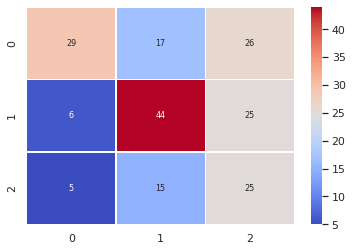

In [ ]:
# Confusion matrix

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
import matplotlib.pyplot as plt
import seaborn as sn
names = [0,1,2]
cm = confusion_matrix(np.array(trues).flatten(), np.array(preds).flatten())
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

In [ ]:
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("validate", val_loader, tweet_model)

validate::   0%|          | 0/3 [00:00<?, ?it/s]

validate : (loss 1.0909170309702556) (acc 0.4270833333333333)


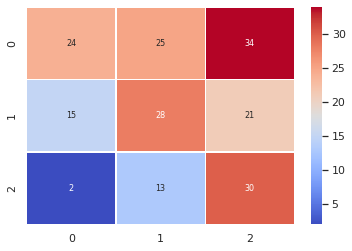

In [ ]:
# Confusion matrix

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
import matplotlib.pyplot as plt
import seaborn as sn
names = [0,1,2]
cm = confusion_matrix(np.array(trues).flatten(), np.array(preds).flatten())
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

## Applying the model to the study dataset

In [ ]:
# Import data
git_url = "https://raw.githubusercontent.com/mthsansu/MLNLP/main/Data/"
df = pd.read_csv(git_url + 'Tweets_sample_confinement.csv', index_col =0)

In [ ]:
import pyarrow as pa
import pyarrow.dataset as ds
from datasets import Dataset

### convert to Huggingface dataset
df_conf = Dataset(pa.Table.from_pandas(df))

In [ ]:
df_conf = df_conf.map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)

  0%|          | 0/33 [00:00<?, ?ba/s]

In [ ]:
# Create the Dataset class

from torch.utils.data import Dataset

class TweetDatasetId(Dataset):
    def __init__(self, data, args):
      # args is a dict, a nice way to share the global arguments (even accross multiple files)
      self.args = args
      self.data = data

    def __len__(self):
      return len(self.data)
    
    def __getitem__(self, idx):
      item = {
          "text": np.array(self.data[idx]['text']),
          "id": np.array(self.data[idx]['id'])
      }
      return item

In [ ]:
# Create the data loader

# Create DataLoader
from torch.utils.data import DataLoader
args = {'bsize': 64}
df_conf_loader = DataLoader(TweetDatasetId(df_conf, args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)

In [ ]:
id_conf,pred_conf = predict("data_conf", df_conf_loader, tweet_model)

data_conf::   0%|          | 0/511 [00:00<?, ?it/s]

In [ ]:
df_pred = pd.DataFrame({"id": id_conf,"pred": pred_conf})

In [ ]:
df_pred

,id,pred
0,1235248385810141184,2
1,1243460617157193728,2
2,1253694529930231812,2
3,1254819182253944832,2
4,1250053653156835329,0
...,...,...
32699,1263353024963063811,0
32700,1258307216316268545,0
32701,1260276393239359495,2
32702,1250852324278439936,1


In [ ]:
df_pred.pred.value_counts()

2    14264
1    11464
0     6976
Name: pred, dtype: int64

# <font color="chillipepper">**Parliamentary sentiment analysis: task-specific modeling using CamemBERT**</font>

### <font color="chillipepper">**GPU Settings**</font>

In [ ]:
if torch.cuda.is_available(): # torch.cuda.is_available() returns a boolean to check if the GPU can be used or not
  device = 'cuda' # if CUDA is available set 'cuda' as the device
  print('DEVICE = ', colored(torch.cuda.get_device_name(0), "green" ) ) # print the name of the GPU
else:
  device = 'cpu' # set 'cpu' as device if CUDA not available
  print('DEVICE = ', colored('CPU', "blue")) # print that the CPU is used
device = torch.device(device) # Set the available device

DEVICE =  Tesla T4


# <font color="chillipepper">**Model building**</font>

### <font color="chillipepper">**Tokenizer**</font>

In [ ]:
# Tokenizer conceived for CamemBERT classification. We use camembert-base
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

### <font color="chillipepper">**Modeling functions**</font>

In [ ]:
# Encoding function
        # `encode` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.  
def encode(sentences, labels=None, tokenizer=tokenizer, batch_size=32, progress_bar=True):
    input_ids = []
    if progress_bar:
        sent_loader = tqdm(sentences)
    else:
        sent_loader = sentences
    for sent in sent_loader:
        encoded_sent = tokenizer.encode(sent,                       # Sentence to encode
                                        add_special_tokens = True,   # Add '[CLS]' token to the start and '[SEP]' token to the end
                                        max_length = 512)          # Truncate all sentences
        input_ids.append(encoded_sent)
        
    MAX_LEN = min(max([len(sen) for sen in input_ids]), 512)

    # Pad our input tokens with value 0.
    # "post" indicates that we want to pad and truncate at the end of the sequence, as opposed to the beginning.
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")

    # Create attention masks
    attention_masks = []
    if progress_bar:
        input_loader = tqdm(input_ids)
    else:
        input_loader = input_ids
    for sent in input_loader:
        # Create the attention mask.
        #   - If a token ID is 0, then it's padding, set the mask to 0.
        #   - If a token ID is > 0, then it's a real token, set the mask to 1.
        att_mask = [int(token_id > 0) for token_id in sent]

        attention_masks.append(att_mask)
    
    if labels is None:
        # Convert to pytorch tensors
        inputs_tensors = torch.tensor(input_ids)
        masks_tensors = torch.tensor(attention_masks)

        # Create the DataLoader 
        data = TensorDataset(inputs_tensors, masks_tensors)
        sampler = SequentialSampler(data)
        dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
        return dataloader        
    else:
        # Convert to pytorch tensors
        inputs_tensors = torch.tensor(input_ids)
        masks_tensors = torch.tensor(attention_masks)
        labels_tensors = torch.tensor(labels)

        # Create the DataLoader 
        data = TensorDataset(inputs_tensors, masks_tensors, labels_tensors)
        sampler = SequentialSampler(data)
        dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
        return dataloader

In [ ]:
# Function to return time elapsed
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded)) # Format as hh:mm:ss

In [ ]:
# Model training
def run_training(train_dataloader, # train data
                 test_dataloader, # test data
                 n_epochs=3, # number of epochs
                 lr=5e-5, # learning rate
                 seed_val=2018, 
                 save_model_as=None): # saving the model to implement it on other data later
    
    # Unpack all test labels for evaluation
    test_labels = []
    for batch in test_dataloader:
        test_labels += batch[2].numpy().tolist()
    num_labels = np.unique(test_labels).size
    
    # Set the seed value all over the place to make this reproducible.
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)
    
    # Load model
    model = CamembertForSequenceClassification.from_pretrained("camembert-base", 
                                                               num_labels = num_labels, 
                                                               output_attentions = False, 
                                                               output_hidden_states = False)
    # Tell pytorch to run this model on the GPU.
    model.cuda()
    
    optimizer = AdamW(model.parameters(), lr = lr, eps = 1e-8)
    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=len(train_dataloader) * n_epochs)
    #total number of training steps is number of batches * number of epochs.

    # Store the average loss after each epoch so we can plot them.
    train_loss_values = []
    test_loss_values = []

    # TRAINING
    
    for i_epoch in range(n_epochs): # each epoch
        # Perform one full pass over the training set.   
        print("")
        print('======== Epoch {:} / {:} ========'.format(i_epoch + 1, n_epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total train loss for this epoch.
        total_train_loss = 0
        total_test_loss = 0  # Reset the total train loss for this epoch.

        # Put the model in training mode
        model.train()

        for step, train_batch in enumerate(train_dataloader): # each batch
            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)
                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            b_inputs = train_batch[0].to(device)
            b_masks = train_batch[1].to(device)
            b_labels = train_batch[2].to(device)

            # Clear any previously calculated gradients before performing a
            model.zero_grad()        

            # Perform a forward pass (evaluate the model on this training batch).
            # This will return the loss (rather than the model output) because we have provided the `labels`.
            outputs = model(b_inputs, token_type_ids=None, attention_mask=b_masks,labels=b_labels)

            # The call to `model` always returns a tuple, so we need to pull the loss value out of the tuple.
            loss = outputs[0]

            # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end.
            # `loss` is a Tensor containing a single value; the `.item()` function just returns the Python value from the tensor.
            total_train_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1. This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()
            
        # Calculate the average loss over the training data batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            

        # Store the loss value for plotting the learning curve.
        train_loss_values.append(avg_train_loss)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

        # VALIDATION
        # After the completion of each training epoch, measure our performance on our validation set.
        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
        model.eval()

        logits_complete = [] # store logits of each batch

        # Evaluate data for one epoch
        for test_batch in test_dataloader:
            # Add batch to GPU
            b_inputs = test_batch[0].to(device)
            b_masks = test_batch[1].to(device)
            b_labels = test_batch[2].to(device)

            # Telling the model not to compute or store gradients, saving memory and speeding up validation
            with torch.no_grad():        
                # Forward pass, calculate test loss and logit predictions.
                # token_type_ids = None : it's not 2-sentences task
                outputs = model(b_inputs, token_type_ids=None, attention_mask=b_masks,labels=b_labels)

            loss = outputs[0].item() # get loss
            logits = outputs[1]      # get logits
            
            # Move logits CPU
            logits = logits.detach().cpu().numpy()
            #labels_id = b_labels.to('cpu').numpy()
            
            total_test_loss += loss
            logits_complete.append(logits)
            
        logits_complete = np.concatenate(logits_complete)
        
        # Calculate the average loss over the test data batches.
        avg_test_loss = total_test_loss / len(test_dataloader)            
        # Store the loss value for plotting the learning curve.
        test_loss_values.append(avg_test_loss)
        
        print("")
        print("  Average test loss: {0:.2f}".format(avg_test_loss))
        print("  Validation took: {:}".format(format_time(time.time() - t0)))
        print(classification_report(test_labels, np.argmax(logits_complete, axis=1).flatten()))
        score = precision_recall_fscore_support(test_labels, np.argmax(logits_complete, axis=1).flatten())

    # End of all epochs
    print("")
    print("Training complete!")
    
    if save_model_as is not None:
        # SAVE
        output_dir = "./models/{}".format(save_model_as)
        try:
            os.makedirs(output_dir)
        except:
            pass
        
        # Step 1: Save a model, configuration and vocabulary that you have fine-tuned
        # If we have a distributed model, save only the encapsulated model
        # (it was wrapped in PyTorch DistributedDataParallel or DataParallel)
        model_to_save = model.module if hasattr(model, 'module') else model

        # If we save using the predefined names, we can load using `from_pretrained`
        output_model_file = os.path.join(output_dir, WEIGHTS_NAME)
        output_config_file = os.path.join(output_dir, CONFIG_NAME)

        torch.save(model_to_save.state_dict(), output_model_file)
        model_to_save.config.to_json_file(output_config_file)
        tokenizer.save_vocabulary(output_dir)

    return score

In [ ]:
# Predict function
def predict(dataloader, model, proba=True, progress_bar=True):
    logits_complete = []
    # Evaluate data for one epoch
    if progress_bar:
        loader = tqdm(dataloader)
    else:
        loader = dataloader
    for batch in loader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        if len(batch)==3:
            b_input_ids, b_input_mask, _ = batch
        else:
            b_input_ids, b_input_mask = batch

        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():        
            outputs = model(b_input_ids, 
                            token_type_ids=None,  # not a 2-sentence task
                            attention_mask=b_input_mask)

        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        logits_complete.append(logits)
        
        del outputs        
        torch.cuda.empty_cache() #release GPU memory
        
        pred = np.concatenate(logits_complete) #flatten batches
    if proba:
        return softmax(pred, axis=1)
    else:
        return pred

In [ ]:
# Apply the trained model on a corpus
def predict_with_model(dataloader, model_path, proba=True):
    model = CamembertForSequenceClassification.from_pretrained(model_path)
    model.cuda()
    return predict(dataloader, model, proba)

# <font color="chillipepper">**Model training**</font>

### <font color="chillipepper">**Annotated data**</font>

In [ ]:
# The data are provided in the github repository
git_url = "https://raw.githubusercontent.com/mthsansu/MLNLP/main/Data/"
df = pd.read_csv(git_url + 'df_baseline.csv', index_col =0, engine='python')

In [ ]:
df["text"] = df["text"].apply(lambda x: clean(x))
# df = df.rename(columns={"label_sansu":"value"})
df = df.rename(columns={"Label":"value"})
df = df[["text","value"]]

In [ ]:
# Show the distribution of labels in human-annotated sample
df.value.value_counts()

0    377
1    368
2    255
Name: value, dtype: int64

### <font color="chillipepper">**Train and test sets**</font>

In [ ]:
# Randomly split the data into 2 samples 'train' and 'test' for the execution of ML tasks
train, test = train_test_split(df, test_size=0.2)

In [ ]:
test.head()

,text,value
979,Bonne FeteNationale ! 14Juillet,1
703,"Des questions, des problèmes ou des inquiétude...",0
130,47 propositions : Déconstruction du tabou des ...,0
574,<U+0001F4C6> Voici mon agenda prévisionnel de ...,0
140,"<U+0001F4F9> ""Je suis pour un grand référendum...",2


In [ ]:
# Encode the 'train' and 'test' samples using the `encode()` function defined above
train_dataloader = encode(train.text.values, train.value.values, batch_size=32)
test_dataloader = encode(test.text.values, test.value.values, batch_size=256)

  0%|          | 0/800 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

### <font color="chillipepper">**Perform train step**</font>

In [ ]:
score = run_training(train_dataloader, 
                                  test_dataloader, 
                                  n_epochs=3, 
                                  lr=5e-5, 
                                  seed_val=2018, 
                                  save_model_as="sentiment_tweet")

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 


======== Epoch 1 / 3 ========
Training...

  Average training loss: 1.02
  Training epcoh took: 0:00:28

Running Validation...

  Average test loss: 0.87
  Validation took: 0:00:02
              precision    recall  f1-score   support

           0       0.67      0.82      0.74        77
           1       0.77      0.61      0.68        76
           2       0.74      0.72      0.73        47

    accuracy                           0.71       200
   macro avg       0.73      0.72      0.71       200
weighted avg       0.72      0.71      0.71       200


======== Epoch 2 / 3 ========
Training...

  Average training loss: 0.74
  Training epcoh took: 0:00:30

Running Validation...

  Average test loss: 0.67
  Validation took: 0:00:02
              precision    recall  f1-score   support

           0       0.71      0.79      0.75        77
           1       0.79      0.66      0.72        76
           2       0.75      0.81      0.78        47

    accuracy                         

# <font color="chillipepper">**Model evaluating**</font>

In [ ]:
# Encode the 'values' column in the test set to prepare it for prediction
predict_loader = encode(test.text.values)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
# Apply our model on the dataloader encoded in the previous cell
pred = predict_with_model(predict_loader, model_path='./models/sentiment_tweet/', proba=True)

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
# We get the label prediction and probability of prediction
test['pred'] = np.argmax(pred, axis=1)
test['prob_1'] = pred[:,1]

In [ ]:
test.pred.value_counts()

0    87
1    61
2    52
Name: pred, dtype: int64

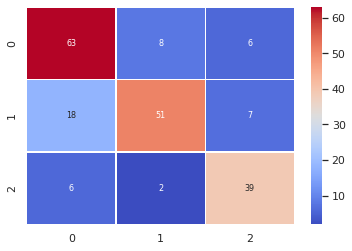

In [ ]:
# Confusion matrix
names = [0,1,2]
cm = confusion_matrix(np.array(test.value.tolist()).flatten(), np.array(test.pred.tolist()).flatten())
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

In [ ]:
# Cross Validation Classification Report
report = classification_report(np.array(test.value.tolist()).flatten(), np.array(test.pred.tolist()).flatten())
print(report)

              precision    recall  f1-score   support

           0       0.72      0.82      0.77        77
           1       0.84      0.67      0.74        76
           2       0.75      0.83      0.79        47

    accuracy                           0.77       200
   macro avg       0.77      0.77      0.77       200
weighted avg       0.77      0.77      0.76       200



# <font color="chillipepper">**Applying the model**</font>

### <font color="chillipepper">**Data to classify**</font>

In [ ]:
# List of samples we want to work on
list_data = ['Tweets_sample_confinement', 'Tweets_sample_benalla', 'Tweets_sample_CDM']

### <font color="chillipepper">**Classification loop**</font>

In [ ]:
for i in range(2,len(list_data)):
  df_study = pd.read_csv(git_url + list_data[i] + '.csv', index_col =0, engine='python')
  df_study["text"] = df_study["text"].apply(lambda x: clean(x))
  df_study_loader = encode(df_study.text.values)
  pred_df_study = predict_with_model(df_study_loader, model_path='./models/sentiment_tweet/', proba=True)
  df_study['pred'] = np.argmax(pred_df_study, axis=1)
  df_study['prob_1'] = pred_df_study[:,1]
  df_study.to_csv(ist_data[i] + '_pred.csv')

  0%|          | 0/31204 [00:00<?, ?it/s]

  0%|          | 0/31204 [00:00<?, ?it/s]

  0%|          | 0/976 [00:00<?, ?it/s]

# <font color="chillipepper">**Interpretations**</font>

In [ ]:
df_study = pd.read_csv(list_data[0] + '_pred.csv', index_col =0, engine='python')
df_study['date'] = pd.to_datetime(df_study['created_at']).dt.date
df_study.head()

,author_id,possibly_sensitive,id,text,created_at,twitter,sexe,age,majo,num_deptmt,groupe_sigle,parti_ratt_financier,nb_mandats,age_group,pred,prob_1
1992377,902788871460724740,False,1004651573933469696,"DirectAn J'étais représentée au colloque ""Agri...",2018-06-07T09:09:35.000Z,FranceLorho,F,52,False,84,NI,Non d<e9>clar<e9>(s),2,3,0,0.199982
1992378,902788871460724740,False,1004619313570045952,<U+0001F1EB><U+0001F1F7> J'ai interrogé . sur ...,2018-06-07T07:01:23.000Z,FranceLorho,F,52,False,84,NI,Non d<e9>clar<e9>(s),2,3,0,0.141570
1992380,902788871460724740,False,1004252252675166208,<U+0001F1EB><U+0001F1F7>Laïcité : ils ne saven...,2018-06-06T06:42:49.000Z,FranceLorho,F,52,False,84,NI,Non d<e9>clar<e9>(s),2,3,2,0.127925
1992381,902788871460724740,False,1003539030775132160,<U+0001F1E8><U+0001F1F2> Cameroun : les popula...,2018-06-04T07:28:44.000Z,FranceLorho,F,52,False,84,NI,Non d<e9>clar<e9>(s),2,3,2,0.145929
1992382,902788871460724740,False,1002493283753431042,<U+0001F1F8><U+0001F1E6>Les nouvelles amitiés ...,2018-06-01T10:13:18.000Z,FranceLorho,F,52,False,84,NI,Non d<e9>clar<e9>(s),2,3,2,0.147763
